In [1]:
from astropy.table import QTable
from astropy.io import fits

In [2]:
# root_inputdir_table = '/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_misc/compact_clusters/'
# inputfile_table = 'PHANGS_IR4_ngc628c_phangs_hst_v1p2_human_class12.fits'

# root_inputdir_halpah = '/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha/ngc628c/hst_contsub/'
# inputfile_halpah = 'ngc628c_muse_ha_as2.fits'

# # Read in the table and the Halpha image
# table_clusters = QTable.read(f'{root_inputdir_table}{inputfile_table}')

# # The Halpha image is a fits file, so we use astropy's fits.open() function to read it in
# hdu_halpah = fits.open(f'{root_inputdir_halpah}{inputfile_halpah}')[0]

# table_clusters['PHANGS_RA', 'PHANGS_DEC']

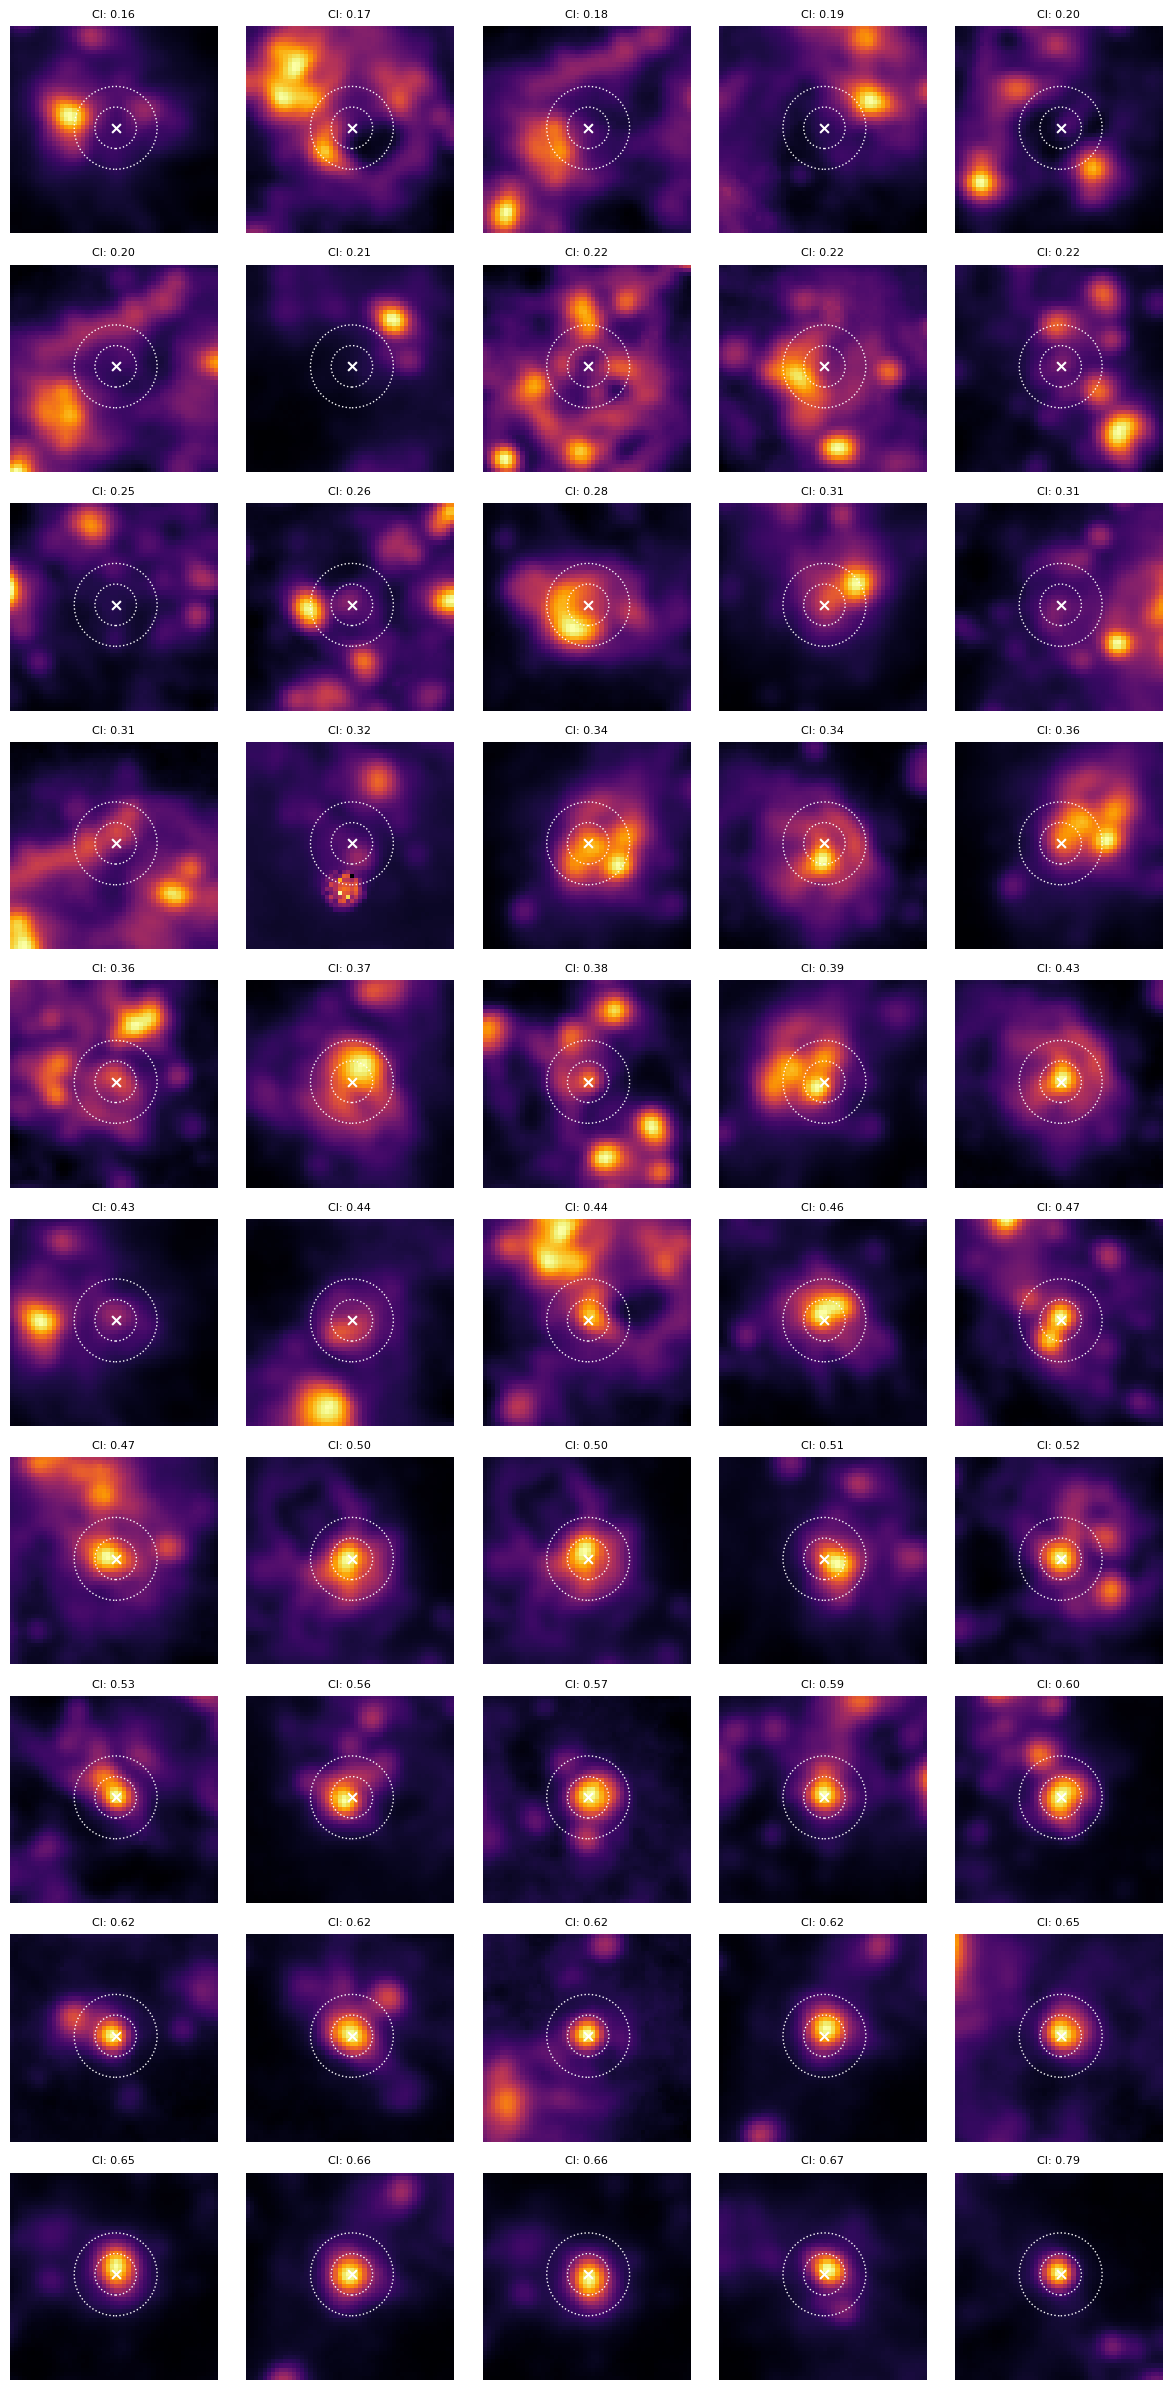

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import QTable
from astropy.io import fits
from astropy.wcs import WCS

# ------------------------------
# 1. Read in the table and Hα image
# ------------------------------
root_inputdir_table = '/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_misc/compact_clusters/'
inputfile_table = 'PHANGS_IR4_ngc628c_phangs_hst_v1p2_human_class12.fits'

root_inputdir_halpah = '/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha/ngc628c/hst_contsub/'
inputfile_halpah = 'ngc628c_muse_ha_as2.fits'

# Read the cluster catalogue
table_clusters = QTable.read(f'{root_inputdir_table}{inputfile_table}')

# Limit to only 1Myr 
age = np.log10(table_clusters['PHANGS_AGE_MINCHISQ']*1e6)
table_clusters = table_clusters[age == 6]

# Read the Hα image
hdu_halpah = fits.open(f'{root_inputdir_halpah}{inputfile_halpah}')[0]
halpha_data = hdu_halpah.data
halpha_header = hdu_halpah.header
halpha_wcs = WCS(halpha_header)

# ------------------------------
# 2. Get RA and Dec from the table
# ------------------------------
ra_clusters = table_clusters['PHANGS_RA']
dec_clusters = table_clusters['PHANGS_DEC']

# ------------------------------
# Helper functions
# ------------------------------
def extract_stamp(image, center_x, center_y, half_size, pad_value=np.nan):
    """
    Extract a postage stamp of size (2*half_size, 2*half_size) from the image
    centered at (center_x, center_y). If the stamp goes off the edge of the image,
    pad the missing pixels with pad_value.
    """
    stamp_size = 2 * half_size
    stamp = np.full((stamp_size, stamp_size), pad_value, dtype=image.dtype)
    
    # Round center coordinates to the nearest pixel
    center_x = int(np.round(center_x))
    center_y = int(np.round(center_y))
    
    # Define the stamp bounds in the image coordinates
    x0, x1 = center_x - half_size, center_x + half_size
    y0, y1 = center_y - half_size, center_y + half_size
    
    # Get image boundaries
    ny, nx = image.shape
    x_start = max(0, x0)
    x_end = min(nx, x1)
    y_start = max(0, y0)
    y_end = min(ny, y1)
    
    # Corresponding indices in the stamp
    stamp_x0 = x_start - x0
    stamp_x1 = stamp_x0 + (x_end - x_start)
    stamp_y0 = y_start - y0
    stamp_y1 = stamp_y0 + (y_end - y_start)
    
    stamp[stamp_y0:stamp_y1, stamp_x0:stamp_x1] = image[y_start:y_end, x_start:x_end]
    
    return stamp

def compute_concentration_index(stamp, inner_radius, outer_radius):
    """
    Compute the concentration index (CI) of a postage stamp.
    
    Here, CI is defined as the ratio of the flux within the inner aperture to 
    the flux within the outer aperture (which should enclose the inner one).
    
    Parameters
    ----------
    stamp : 2D numpy array
        The postage stamp image.
    inner_radius : float
        Radius (in pixels) of the inner aperture.
    outer_radius : float
        Radius (in pixels) of the outer aperture.
    
    Returns
    -------
    ci : float
        The concentration index. Returns np.nan if the outer aperture has zero flux.
    """
    size = stamp.shape[0]
    # Create a coordinate grid
    y, x = np.indices((size, size))
    # Assume the center is at the middle of the stamp
    center = (size / 2, size / 2)
    r = np.sqrt((x - center[1])**2 + (y - center[0])**2)
    
    # Define the inner and outer masks
    inner_mask = r <= inner_radius
    outer_mask = r <= outer_radius
    
    # Sum the fluxes (ignoring NaNs)
    flux_inner = np.nansum(stamp[inner_mask])
    flux_outer = np.nansum(stamp[outer_mask])

    # Check if nan value is stamp[inner_mask] and stamp[outer_mask], if so return nan
    if np.isnan(stamp[inner_mask]).any() or np.isnan(stamp[outer_mask]).any():
        return np.nan
    
    if (flux_outer > 0) & (flux_inner > 0):
        return flux_inner / flux_outer
    else:
        return np.nan

# ------------------------------
# 3. Extract stamps and compute concentration index for each cluster
# ------------------------------
# Parameters for the stamps and apertures
stamp_half_size = 25   # stamp will be 50 x 50 pixels
inner_radius = 5       # inner aperture radius (in pixels)
outer_radius = 10      # outer aperture radius (in pixels)

concentration_indices = []  # to hold CI values for each cluster
stamps = []                 # to store stamps (for later visualization)

for ra, dec in zip(ra_clusters, dec_clusters):
    # Convert cluster RA,Dec to pixel coordinates in the Hα image
    pix_x, pix_y = halpha_wcs.all_world2pix(ra, dec, 0)
    
    # Extract a postage stamp centered at the cluster
    stamp = extract_stamp(halpha_data, pix_x, pix_y, half_size=stamp_half_size, pad_value=np.nan)
    stamps.append(stamp)
    
    # Compute the concentration index for this stamp
    ci = compute_concentration_index(stamp, inner_radius, outer_radius)
    concentration_indices.append(ci)

# ------------------------------
# 4. Add the concentration index back into the table
# ------------------------------
table_clusters['concentration_index'] = concentration_indices

# ------------------------------
# 5. Select 25 examples from low to high concentration index and make a 5x5 panel
# ------------------------------
# Sort indices by concentration index (ignoring NaNs by putting them at the end)
# Convert the list to a NumPy array for easier masking
ci_array = np.array(concentration_indices)

# Create a mask for non-NaN values
valid_mask = ~np.isnan(ci_array)

# Get the indices of clusters with valid CI values
valid_indices = np.where(valid_mask)[0]

# Sort the valid indices by their concentration index
sorted_valid_indices = valid_indices[np.argsort(ci_array[valid_indices])]

n_examples = 50

if len(sorted_valid_indices) < n_examples:
    print("Warning: Not enough clusters with valid CI for 25 examples.")
    selected_indices = sorted_valid_indices
else:
    # Evenly select 25 indices along the sorted valid indices
    selected_indices = sorted_valid_indices[np.linspace(0, len(sorted_valid_indices) - 1, n_examples, dtype=int)]

# Create a 5x5 panel
fig, axes = plt.subplots(10, 5, figsize=(12, 24))
for ax, idx in zip(axes.flat, selected_indices):
    stamp = stamps[idx]
    ci = concentration_indices[idx]
    # Optionally apply a square-root stretch for visualization
    im = ax.imshow(np.sqrt(stamp), origin='lower', cmap='inferno')
    ax.scatter(stamp_half_size, stamp_half_size, marker='x', color='white', s=40)
    # add inned and outer aparature
    circle1 = plt.Circle((stamp_half_size, stamp_half_size), inner_radius, color='white', fill=False, linestyle='dotted')
    circle2 = plt.Circle((stamp_half_size, stamp_half_size), outer_radius, color='white', fill=False, linestyle='dotted')
    ax.add_artist(circle1)
    ax.add_artist(circle2)
    ax.set_title(f"CI: {ci:.2f}", fontsize=8)
    ax.axis('off')

plt.tight_layout()
plt.show()

Text(0, 0.5, 'Concentration Index')

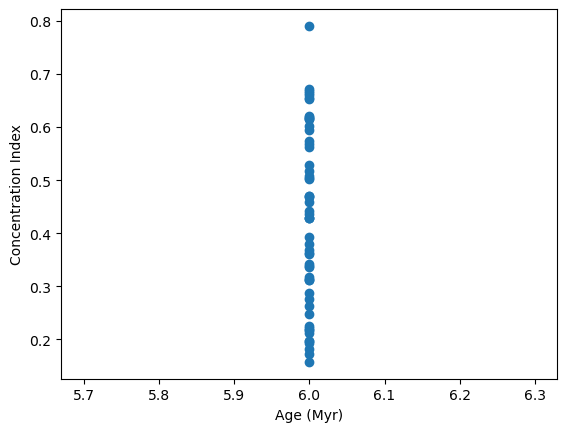

In [15]:
plt.scatter(np.log10(table_clusters['PHANGS_AGE_MINCHISQ']*1e6), table_clusters['concentration_index'])
plt.xlabel('Age (Myr)')
plt.ylabel('Concentration Index')
